# **COMP3670/6670 Assignment 3 - GMM**
---

**Enter Your Student ID: u6668002

**Your Name: Thomas Krnc
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'uXXXXXXX.ipynb' for programming and 'uXXXXXXX.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**
- <Enter ID 1>
- <Enter ID 2>
- <Enter ID 3>
    

**Programming Section**
- 1 = 20%
- 2 = 20%
- 3 = 20%
- 4 = 7.5%
- 5 = 7.5%
- 6.1 = 5%
- 6.2 = 20%

---


**PROGRAMMING SECTION**
---


For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

In [331]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import functools
from scipy.stats import multivariate_normal

We're going to implement an algorithm to model data with a mixture of gaussians. 

Remember the simplified EM algorithm in assignment 2 for k-means? Well, we're going to implement something similar.

The more complex aspect of this all is that your program must also correctly estimate the covariance matrices of the 2-dimensional gaussian components involved, as well as their means.

Not only this, but the "distance" of each of your data points (a row $d_i$ of $D$) from a gaussian $k$, is the probability of that point given that gaussian $p(d_i \mid k)$. 

Run the below cell to load the data we'll be using.

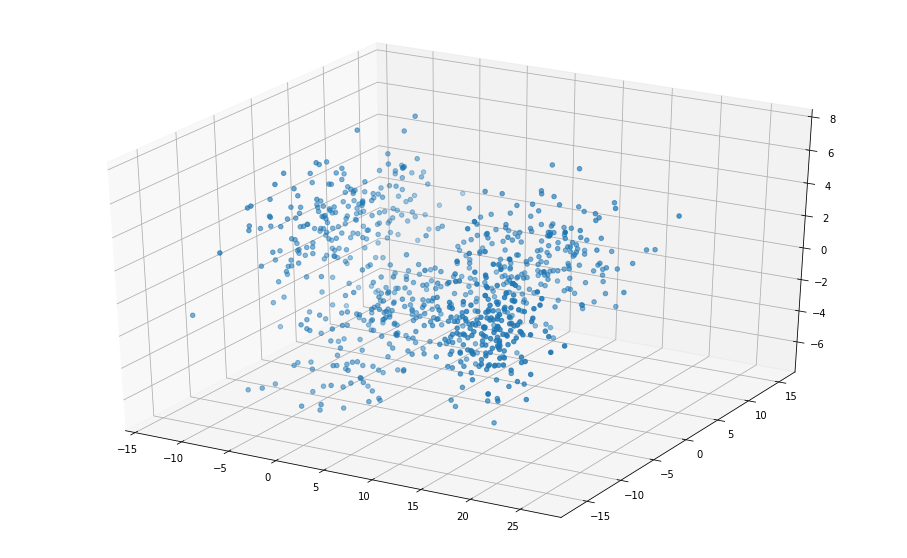

In [332]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 5 dimensions. The contribution of first three dimensions represented by a three dimensional Gaussian Mixture Model. The forth and fifth dimensions represented by another two dimensional GMM. 

**You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. For example, the first gaussian is $k = 1$. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilities, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

**REPEAT: You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

---

In [346]:
def initialise_parameters(X, K):
    # YOUR CODE HERE
    #k = r.shape[1] (# of guasians)
    #m = X.shape[1] (# of random variables)
    M = X.shape[1]
    #n = r.shape[0], X.shape[0] (# of datapoints)
    N = X.shape[0]
    
    #mu, List of K datapoints to be the mean of each guasian
    mu = np.zeros((K, M))

    indexs = np.random.choice(X.shape[0], K, replace="False")
    for k in range(K):
        mu[k] = X[k]
   
    
    #SIGMA, list of K covariance matrixs. 
    sigma = np.zeros((K, M, M))
   
    y = np.zeros(X.shape)
    
    #fill in sigma for each K
    for k in range(K):

        #calculate each datapoint - mean
        for i in range(X.shape[0]):
            y[i] = X[i] - mu[k]

        #generate m by m covariance matrix
        s = 1/y.shape[0] * y.transpose() @ y
       
        #make it positive definitive
        for i in range(s.shape[0]):
            for j in range(s.shape[1]):
                if (s[i,j] < 0):
                      s[i,j] = -s[i,j]
        sigma[k] = s

    
    #PI
    pi = 1/K * np.ones(K)
    
    return sigma, mu, pi


def mean(L):
    if (L.size == 0):
        return 0
    
    count = 0
    for i in L:
        count = count + i
        
    return count/L.size


K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[129.47195657  66.79027599   6.69943882]
  [ 66.79027599  96.64341061  12.20647027]
  [  6.69943882  12.20647027   8.14814845]]

 [[342.75192805 165.13045829  22.40337788]
  [165.13045829 121.67212138   9.1530236 ]
  [ 22.40337788   9.1530236    9.01546019]]

 [[320.50652327 163.680656    16.08224467]
  [163.680656   128.06243965  13.99259403]
  [ 16.08224467  13.99259403   8.11035895]]

 [[154.29282862  82.72368501  23.33415466]
  [ 82.72368501 101.19496493  27.44706406]
  [ 23.33415466  27.44706406  15.63009761]]]

Mu: 
 [[ 11.38557226 -10.30150224  -1.15348055]
 [ 21.09144213 -11.78128224   1.34179732]
 [ 20.37296115 -12.1223779   -1.13573862]
 [ 13.15385151 -10.59097687  -3.01818618]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depends on the probability of that datapoint given that gaussian.

You cannot use euclidean distance like you did with the k-means algorithm in assignment 3.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [334]:
def E_step(pi, mu, sigma, X):
    #k = r.shape[1] (# of guasians)
    K = pi.shape[0]
    #m = X.shape[1] (# of random variables)
    M = X.shape[1]
    #n = X.shape[0] (# of datapoints)
    N = X.shape[0]
    
    r = np.zeros((N, K))
    for n in range(N):
        sum1 = 0
        for k in range(K):
            r[n,k] = pi[k] * multivariate_normal.pdf(X[n], mean=mu[k], cov=sigma[k])
            sum1 = sum1 + r[n,k]
        for k in range(K):
            r[n,k] = r[n,k] / sum1

    return r

responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)

[[0.41216001 0.134476   0.17019591 0.28316808]
 [0.16437883 0.44125577 0.30058195 0.09378345]
 [0.2390069  0.21863831 0.34920329 0.1931515 ]
 ...
 [0.59987988 0.02308135 0.02581114 0.35122762]
 [0.58712047 0.02617373 0.03122654 0.35547926]
 [0.55359995 0.02295818 0.01439483 0.40904703]]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

**HINT:** 
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [335]:
def M_step(r, X):
    # YOUR CODE HERE
    #k = r.shape[1] (# of guasians)
    K = r.shape[1]
    #m = X.shape[1] (# of random variables)
    M = X.shape[1]
    #n = r.shape[0], X.shape[0] (# of datapoints)
    N = r.shape[0]
    
    #mu, List of K datapoints to be the mean of each guasian (k,m)
    mu = np.zeros((K, M))
    #SIGMA, list of K covariance matrixs. 
    sigma = np.zeros((K, M, M))
    #PI
    pi = np.zeros((K))
    Nk = np.zeros((K))
    
    for n in range(N):
        Nk = Nk + r[n] 
    
    for k in range(K):
        musum = np.zeros((M))
        sigmasum = np.zeros((M, M))
        for n in range(N):
            musum = musum + r[n,k] * X[n]
        mu[k] = 1/Nk[k] * musum
        
        for n in range(N):
            sigmasum = sigmasum + r[n,k] * np.outer(X[n] - mu[k],X[n] - mu[k])
        
        for i in range(M):
            for j in range(M):
                if (sigmasum[i,j] < 0):
                    sigmasum[i,j] = -sigmasum[i,j]
        
        sigma[k] = 1/Nk[k] * sigmasum
        pi[k] = Nk[k]/r.shape[0]
    

    return mu, sigma, pi


mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[84.31404623  9.660007    3.56976826]
  [ 9.660007   30.91037507  3.68830361]
  [ 3.56976826  3.68830361  6.37761294]]

 [[52.07178928 14.34197234  7.20768026]
  [14.34197234 18.63382737  1.84786825]
  [ 7.20768026  1.84786825  5.94244658]]

 [[52.43704915 13.97673011  1.89467686]
  [13.97673011 21.44672443  0.95280038]
  [ 1.89467686  0.95280038  4.6930833 ]]

 [[75.18787145  4.7720354   3.04190727]
  [ 4.7720354  31.8100698   7.04137093]
  [ 3.04190727  7.04137093  7.85930137]]]

Mu: 
 [[ 2.88782013 -0.96221438  0.25950505]
 [14.54831118 -9.19167992  0.68311529]
 [13.98479368 -8.79300839  0.01963856]
 [ 5.11702369 -2.38704036 -0.89335505]]

Pi: 
 [0.54477576 0.077316   0.06986491 0.30804333]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [336]:
def classify(pi, mu, sigma, x):
    # YOUR CODE HERE
    maxIndex = 0
    maxValue = pi[0] * multivariate_normal.pdf(x, mean=mu[0], cov=sigma[0])
    for i in range(1, pi.size):
        temp = pi[i] * multivariate_normal.pdf(x, mean=mu[i], cov=sigma[i])
        if (temp > maxValue):
            maxIndex = i
            maxValue = temp
        
    return maxIndex
print(classify(pi, mu, sigma, X[270, :3]))

0


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [[[ 2.21644896  4.5571401   0.60479092]
  [ 4.5571401  24.93914558  1.1619099 ]
  [ 0.60479092  1.1619099   4.29231294]]

 [[ 3.82516623  0.48913562  0.4294437 ]
  [ 0.48913562  0.90745395  0.10685862]
  [ 0.4294437   0.10685862  4.51636139]]

 [[ 4.50973521  1.02242296  0.88101662]
  [ 1.02242296  1.55071364  0.4830653 ]
  [ 0.88101662  0.4830653   4.06349016]]

 [[43.14861155 17.83046329 10.71619258]
  [17.83046329 21.28369039  7.30866706]
  [10.71619258  7.30866706  6.73067677]]]

Mu: 
 [[ -7.08496603   0.69543128   1.81274865]
 [ 14.40275128  -9.70354196  -0.41841389]
 [ 19.29651137 -12.00526476   0.63147627]
 [  6.38238452  -0.66993953  -1.01990219]]

Pi: 
 [0.2512724  0.14050245 0.08719528 0.52102987]


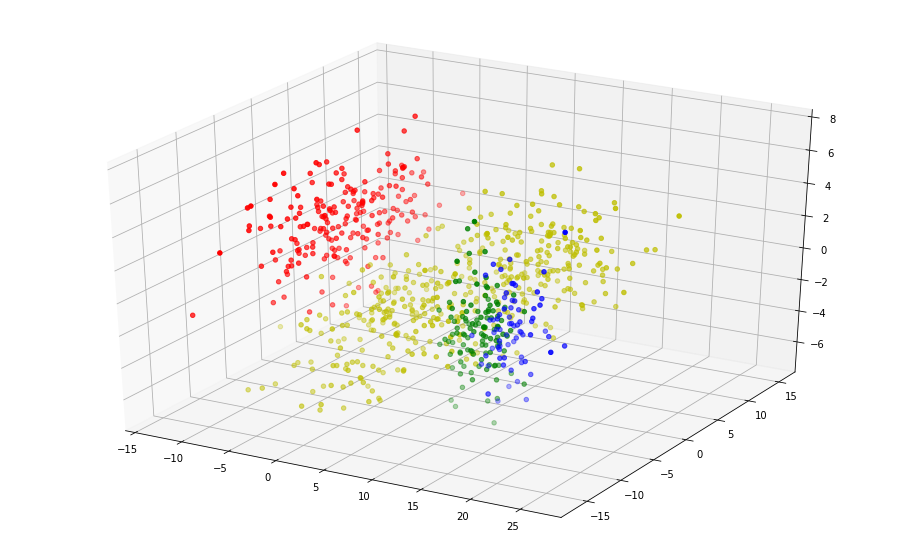

In [337]:
def EM(X, K, iterations):
    # YOUR CODE HERE
    sigma, mu, pi = initialise_parameters(X, K)
    for i in range(iterations):
        responsibilities = E_step(pi, mu, sigma, X)
        mu, sigma, pi = M_step(responsibilities, X)
    return mu, sigma, pi


#Test code. Leave it aloooooone!
iterations = 30
K = 4
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:, 2], c=colours[k])
plt.show()

Now we start to use the forth and fifth dimension. First, we plot the forth and fifth dimension.

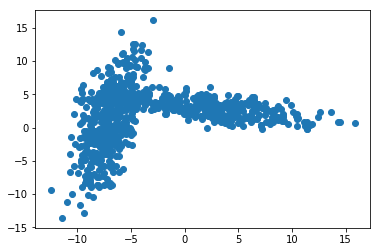

In [338]:
plt.scatter(X[:,3], X[:,4])
plt.show()

It is clearly that the number of Gaussians (K) for the second GMM equals to 2.

**TASK 6.1:** Compute the $\mu, \pi, \Sigma$ of the second GMM

In [339]:
mu_2, sigma_2, pi_2 = EM(X[:, 3:], 2, 30)
print('\nSigma: \n', sigma_2)
print('\nMu: \n', mu_2)
print('\nPi: \n', pi_2)


Sigma: 
 [[[ 2.9144632   4.94423129]
  [ 4.94423129 24.96396698]]

 [[15.78315333  2.18538563]
  [ 2.18538563  1.65443709]]]

Mu: 
 [[-6.87822817  1.33995198]
 [ 3.49370839  2.69225504]]

Pi: 
 [0.64004615 0.35995385]


**TASK 6.2:** Conditional Distribution.

Using the function from the Task 4. Using the $\mu, \pi, \Sigma$ to calculate the conditional distribution.

Let $K$ stands for the classification result of the first three dimensions, $Y$ stands for the classification result of the second dimensions.

Possible $k$ values are 0, 1, 2, 3. Possible $y$ values are 0, 1. 

Compute the conditional distribution $p(Y = y|K = k)$.

In [340]:
def conditional_distribution(X, k, y, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2):
    P = np.zeros((pi_1.shape[0],pi_2.shape[0]))
    for x in range(X.shape[0]):
        a = classify(pi_1, mu_1, sigma_1, X[x,:3])
        b = classify(pi_2, mu_2, sigma_2, X[x,3:])
        P[a,b] = P[a,b] + 1
    return P[k,y] / np.sum(P[k])

In [341]:
a = conditional_distribution(X, 0, 0, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2)
b = conditional_distribution(X, 0, 1, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2)
print(a,b)
print(a + b) # The answer should equal(or almost equal) to one.

0.4827586206896552 0.5172413793103449
1.0
